In [1]:
!pip install spacy==3.2.1
import os, spacy
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import tensorflow_hub as hub
# import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import FileLink

     |████████████████████████████████| 6.0 MB 4.4 MB/s            
  Attempting uninstall: spacy
    Found existing installation: spacy 3.1.4
    Uninstalling spacy-3.1.4:
      Successfully uninstalled spacy-3.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.1.0 requires spacy<3.2.0,>=3.1.0, but you have spacy 3.2.1 which is incompatible.
en-core-web-lg 3.1.0 requires spacy<3.2.0,>=3.1.0, but you have spacy 3.2.1 which is incompatible.
allennlp 2.8.0 requires spacy<3.2,>=2.1.0, but you have spacy 3.2.1 which is incompatible.


In [2]:
nlp = spacy.load('en_core_web_lg')
from tensorflow import keras
from transformers import *

/opt/conda/lib/python3.7/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_lg' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [4]:
max_len = 512

tokenizer = BertTokenizer.from_pretrained('../input/huggingface-bert/bert-large-uncased/vocab.txt')

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1645: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  FutureWarning,


In [5]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [6]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(256, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.4)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.4)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
os.chdir('/kaggle/input/for-document-classification')

In [8]:
# from spacy.lang.en.stop_words import STOP_WORDS
# print(STOP_WORDS)

In [9]:
def filtering(text):
    my_doc = nlp(text)
    token_list = []
    lemma_words = []
    for token in my_doc:
        token_list.append(token.text)
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            lemma_words.append(word)
    return ' '.join(lemma_words)

In [10]:
df = pd.read_csv('train.csv', encoding = 'cp1252')
df = df.sample(frac = 1)
df.head()

,Text,Label
16,College life is full of new experiences and di...,Healthcare
49,Lewis Hamilton may have missed out on a histor...,Sports
1,"Starting from this month, mutual funds have st...",Financial
42,The consumer affairs ministry may drop content...,Financial
43,Oil prices rose on Thursday to extend several ...,Financial


In [11]:
label_list = df['Label'].tolist()

In [12]:
for i in range(len(label_list)):
    if label_list[i] == 'Financial':
        label_list[i] = 0
    elif label_list[i] == 'Healthcare':
        label_list[i] = 1
        
    elif label_list[i] == 'Sports':
        label_list[i] = 2

In [13]:
df['Label'] = label_list

In [14]:
df.head()

,Text,Label
16,College life is full of new experiences and di...,1
49,Lewis Hamilton may have missed out on a histor...,2
1,"Starting from this month, mutual funds have st...",0
42,The consumer affairs ministry may drop content...,0
43,Oil prices rose on Thursday to extend several ...,0


In [15]:
max_len = 512
train_input = bert_encode(df.Text.values, tokenizer, max_len=max_len)
# test_input = bert_encode(test_df.cleaned_text.values, tokenizer, max_len=max_len)
train_labels = df['Label']

In [16]:
train_input

(array([[  101,  2267,  2166, ...,  6245,  1010,   102],
        [  101,  4572,  5226, ...,  2038,  2180,   102],
        [  101,  3225,  2013, ...,  2213,  7705,   102],
        ...,
        [  101,  5325,  1011, ...,  9797,  2071,   102],
        [  101,  3956,  1005, ...,  2353, 13004,   102],
        [  101,  2414,  1024, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [17]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
train_history = model.fit(train_input, train_labels, validation_split=0.2, batch_size= 2, epochs=5, verbose=1)

Epoch 1/5
34/34 [==============================] - 21s 210ms/step - loss: 1.2097 - accuracy: 0.3088 - val_loss: 0.6967 - val_accuracy: 0.8889
Epoch 2/5
34/34 [==============================] - 6s 185ms/step - loss: 0.7929 - accuracy: 0.6471 - val_loss: 0.3834 - val_accuracy: 1.0000
Epoch 3/5
34/34 [==============================] - 6s 181ms/step - loss: 0.4962 - accuracy: 0.8824 - val_loss: 0.2169 - val_accuracy: 1.0000
Epoch 4/5
34/34 [==============================] - 6s 187ms/step - loss: 0.3705 - accuracy: 0.8971 - val_loss: 0.1313 - val_accuracy: 1.0000
Epoch 5/5
34/34 [==============================] - 6s 185ms/step - loss: 0.1890 - accuracy: 0.9853 - val_loss: 0.0818 - val_accuracy: 1.0000


In [19]:
# df['Text'] = df['Text'].apply(filtering)

In [20]:
# df.head()

In [21]:
# df.info()

In [22]:
# def cleaned_text(text):
#     text = re.sub('http\S+', ' ', text)
#     text = re.sub('\d{9,}', ' ', text)
#     text = re.sub('@\S+', ' ', text)
#     text = text.lower()
#     return text

In [23]:
# df['Text'] = df['Text'].apply(cleaned_text)

In [24]:
# df.head()

Text(0.5, 1.0, 'Counts of the classes in the data')

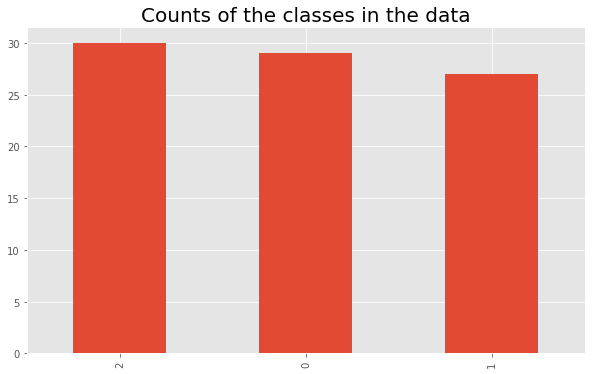

In [25]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
freq=df['Label'].value_counts()
freq.plot(kind="bar")
plt.title('Counts of the classes in the data', size = 20)

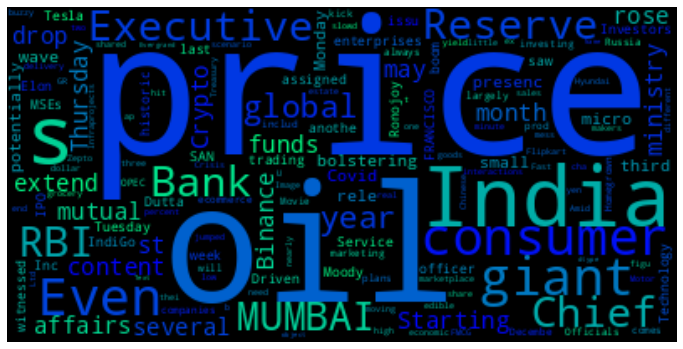

In [26]:
cloud=WordCloud(colormap="winter").generate(str(df[df['Label']==0]["Text"]))
fig=plt.figure(figsize=(12,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

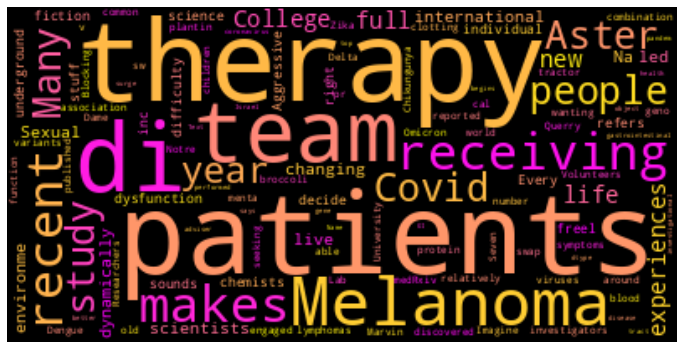

In [27]:
cloud=WordCloud(colormap="spring").generate(str(df[df['Label']==1]["Text"]))
fig=plt.figure(figsize=(12,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

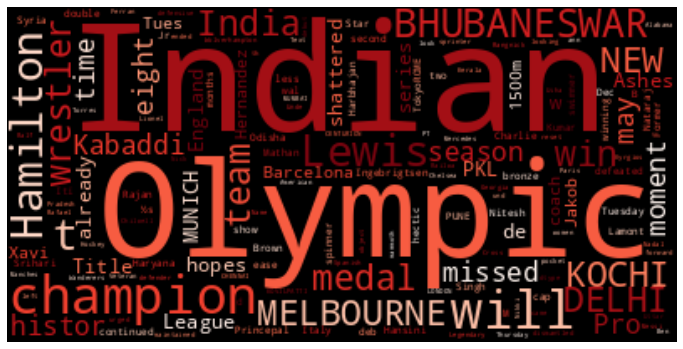

In [28]:
cloud=WordCloud(colormap="Reds").generate(str(df[df['Label']==2]["Text"]))
fig=plt.figure(figsize=(12,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [29]:
# GLOVE_EMB = '/kaggle/input/glove6b/glove.6B.300d.txt'
# EMBEDDING_DIM = 300
# LR = 1e-3
# # BATCH_SIZE = 8
# EPOCHS = 10
# # MODEL_PATH = '/kaggle/working/best_model.hdf5'

In [30]:
# embeddings_index = {}

# f = open(GLOVE_EMB)
# for line in f:
#   values = line.split()
#   word = value = values[0]
#   coefs = np.asarray(values[1:], dtype='float32')
#   embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' %len(embeddings_index))

In [31]:
# TRAIN_SIZE = 0.8
# MAX_NB_WORDS = 100000
# MAX_SEQUENCE_LENGTH = 606

In [32]:
# train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
#                                          random_state=7) # Splits Dataset into Training and Testing set
# print("Train Data size:", len(train_data))
# print("Test Data size", len(test_data))

In [33]:
# train_data.head()

In [34]:
# train_data['Label'].value_counts()

In [35]:
# from keras.preprocessing.text import Tokenizer

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train_data.Text)

# word_index = tokenizer.word_index
# vocab_size = len(tokenizer.word_index) + 1
# print("Vocabulary Size :", vocab_size)

In [36]:
# from keras.preprocessing.sequence import pad_sequences

# x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.Text),
#                         maxlen = MAX_SEQUENCE_LENGTH)
# x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.Text),
#                        maxlen = MAX_SEQUENCE_LENGTH)

# print("Training X Shape:",x_train.shape)
# print("Testing X Shape:",x_test.shape)

In [37]:
# encoder = LabelEncoder()
# encoder.fit(train_data.Label.to_list())

# y_train = encoder.transform(train_data.Label.to_list())
# y_test = encoder.transform(test_data.Label.to_list())

# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)

# y_train, y_test
#     # print("y_train shape:", y_train.shape)
# # print("y_test shape:", y_test.shape)

In [38]:
# embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# for word, i in word_index.items():
#   embedding_vector = embeddings_index.get(word)
#   if embedding_vector is not None:
#     embedding_matrix[i] = embedding_vector

In [39]:
# embedding_layer = tf.keras.layers.Embedding(vocab_size,
#                                           EMBEDDING_DIM,
#                                           weights=[embedding_matrix],
#                                           input_length=MAX_SEQUENCE_LENGTH,
#                                           trainable=False)

In [40]:
# from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
# from tensorflow.keras.layers import SpatialDropout1D
# from tensorflow.keras.callbacks import ModelCheckpoint

In [41]:
# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedding_sequences = embedding_layer(sequence_input)
# x = SpatialDropout1D(0.2)(embedding_sequences)
# x = Conv1D(64, 5, activation='relu')(x)
# x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(128, activation='relu')(x)
# outputs = Dense(3, activation='softmax')(x)
# model = tf.keras.Model(sequence_input, outputs)

In [42]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# model.compile(optimizer=Adam(learning_rate=LR), loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
#                                      min_lr = 0.01,
#                                      monitor = 'val_loss',
#                                      verbose = 1)

In [43]:
# history = model.fit(x_train, y_train, epochs=EPOCHS,
#                     validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

In [44]:
os.chdir('/kaggle/working')
model.save('document_classifier.h5')
# os.chdir('/kaggle/working')
FileLink(r'document_classifier.h5')

/kaggle/working/document_classifier.h5

In [45]:
inputs = ['''Brooklyn Nets star Kevin Durant and Philadelphia 76ers center Joel Embiid had some words for each other toward the end of their game on Thursday night in Brooklyn. Embiid told Durant and the Nets to go back home after Philadelphia won 110-102 in a pivotal Eastern Conference matchup. Embiid was just returning the favor to Durant after the Nets beat the 76ers earlier this month. While the two appeared to have some words on the court, cooler heads prevailed off it and both players showed their respect and admiration for each other after the game.

"That's the best team in the conference. Obviously, I respect him a lot," Embiid said of Durant, via ESPN. "I mean, judging by the way he was acting last time, that's the same thing he told us. Basically, I returned the favor."Embiid added: "There's a lot of respect. I always tell people, I think I can do everything on the basketball court, and there's not a lot of guys that are able to do it. If there was one player that I think is probably as talented, or more talented, than me, it's definitely him. So I have a lot of respect for him. I admire his game. We're just competitive. And wins matter, every single one of them, and it's always good to beat the best team in the conference." "If you've been watching Joel and I play, it's been like that every game -- even the All-Star Game. We just respect each other so much that natural competitive fire, I guess, comes out. It's the name of the game and letting them know we're coming with the same energy. I like the energy that they played with tonight. You love competition; it's only going to make you better." ''', '''Bitcoin’s price was ranging between $46,000 and $48,000 during the weekend, after “crypto witching day” ended Friday with the expiration of roughly $8.67 billion worth of bitcoin and ether options contracts.

Bitcoin, the oldest cryptocurrency, experienced a small price recovery to as high as about $47,961.0 on Saturday, before it fell into red again on Sunday, based on data from TradingView. But its overall spot trading volume across major centralized exchanges declined on the weekend, meaning that the price move was not supported by strong market activities.''', '''As the world continues to witness a rise in COVID-19 cases driven by the Omicron variant, new studies have shown that the new strain of the virus could more likely infect the throat rather than the lungs. Scientists think that the new variant of COVID-19, Omicron, appears to be more infectious, however, it is less deadly than other versions. Six studies have indicated that Omicron does not damage the lungs of the person as much as the Delta variant and other strains of coronavirus used to affect it, reported The Guardian. 

The studies which have made the revelation have not been peer-reviewed by other scientists. Deenan Pillay, professor of virology at University College London, has insisted that the Omicron variant is different from previous variants of COVID-19 as it “may have altered its ability to infect different sorts of cells.” Pillay added that the new variant of COVID-19 appears to infect the “upper respiratory tract -cells in the throat", as per the news report. Pillay further stated that the Omicron variant might have the ability to multiply cells in the throat rather than in the lungs. 

As per The Guardian report, if the virus has the capability to produce more cells in the throat, it means that the virus is more than transmissible. Researchers from the University of Liverpool’s Molecular Virology Research Group published a pre-print that indicated that Omicron leads to “less severe disease in mice.” According to the research, the mice infected with the Omicron variant of COVID-19 have less weight loss, lower virus loads and less severe pneumonia. Prof James Stewart insisted that the animal model shows that the Omicron variant is less severe than the Delta variant and other variants and animals recovered rapidly from the virus, according to the news report. ''', '''India’s problem of plenty on the external sector – too many dollars coming into the country relative to those going out – appears to be coming to an end. After nearly two years of ultra-accommodative monetary policy, the US Federal Reserve (Fed) at its December meeting announced it will double the pace of its balance sheet tapering and end its net asset purchases by mid-March 2022, three months ahead of its earlier schedule. The median projections also show more front loaded rate hikes in 2022 (three hikes) and eight cumulative hikes by the end of 2024.''', '''New Delhi: Delhi may see 20-25,000 cases a day by mid-January and hospitalisations may increase, government sources said today as a top panel discussed new restrictions in the capital. 
At the current rate of infection, Delhi may report 8-9,000 daily cases by January 8, top sources in the Union Health Ministry told NDTV. 

"By January 15, there could be 20-25,000 daily cases in Delhi," the sources said, cautioning against underestimating the Omicron surge.

"Britain has started reporting deaths, so we cannot take the new wave or Omicron lightly. The number of hospitalisations in AIIMS has increased and it is worrying. As cases rise, so will the number of people in hospitals," they asserted. 

Health Ministry officials said both the Omicron and Delta variants are driving Covid cases in the country. 

More than 50 people have been admitted to Delhi's AIIMS in the past two-three days, say hospital sources. 

The premier hospital has cancelled winter vacations and has asked its faculty to rejoin work immediately. New Delhi: Delhi may see 20-25,000 cases a day by mid-January and hospitalisations may increase, government sources said today as a top panel discussed new restrictions in the capital. 
At the current rate of infection, Delhi may report 8-9,000 daily cases by January 8, top sources in the Union Health Ministry told NDTV. 

"By January 15, there could be 20-25,000 daily cases in Delhi," the sources said, cautioning against underestimating the Omicron surge.

"Britain has started reporting deaths, so we cannot take the new wave or Omicron lightly. The number of hospitalisations in AIIMS has increased and it is worrying. As cases rise, so will the number of people in hospitals," they asserted. 

Health Ministry officials said both the Omicron and Delta variants are driving Covid cases in the country. 

More than 50 people have been admitted to Delhi's AIIMS in the past two-three days, say hospital sources. 

The premier hospital has cancelled winter vacations and has asked its faculty to rejoin work immediately. A total of 1,892 cases of the Omicron variant have been found across 23 states and Union Territories and Maharashtra (568) and Delhi (382) top the list. Today, 37,379 new cases were reported in the country.''', '''Everton manager Rafael Benitez has put his faith in Dominic Calvert-Lewin and new signings in January as the Merseysiders look to turn their season around. The England striker made his comeback after over four months out with a thigh injury in a 3-2 home defeat by Brighton on Sunday where he missed a penalty. Prior to the game at Goodison Park, Ukranian left-back Vitaliy Mykolenko was introduced to fans, who was signed for 17 million euros.

British newspaper reports have also linked Benitez with a move for Glasgow Rangers right-back Nathan Patterson as he looks to shore up the defence of an Everton side languishing in 15th place in the 20-strong Premier League.

Sunday's match was only the eighth time this season that have Everton scored more than once in a league fixture, with five of those occasions coming in their opening six games and the 24-year-old Calvert-Lewin scoring in the first three before his injury.

"Hopefully Dominic coming back will give a little bit more hope to everyone," said Spanish boss Benitez after Everton's eighth defeat in 12 league games.

"And if we are bringing players back, and signing new players, it will bring this desire that everyone is expecting."

Prior to kick-off, Brighton had won just once in 13 matches but victory saw the Seagulls soar into eighth place.

Goals have been hard to come by for the south coast side, but a double from midfielder Alexis Mac Allister at Goodison Park was an encouraging sign for Brighton manager Graham Potter.

Listen to the latest songs, only on JioSaavn.com
"He has the quality. He can contribute to the scoring phase for us," said Potter of Mac Allister. "So can others. That is something we are trying to improve as it's too easy to blame the strikers."''', '''Legendary Manchester United manager Sir Alex Ferguson has described Cristiano Ronaldo's second debut for the Red Devils as "Caesar entering Rome". United pulled off one of the biggest signings this year by re-signing Ronaldo from Juventus on deadline day, 12 years on from his initial departure to Real Madrid. On his return, Ronald scored two goals against Newcastle United at Old Trafford and that game was even attended by Ferguson, who had earlier described Ronaldo as his son.

"It's fantastic. You saw on Saturday that it was like Caesar entering Rome after victory. I came, I saw, I conquered. It was fantastic. I mean, for anyone who is a United fan, we could have had a million people in there, without doubt, as there were so many outside, hundreds outside. It's one of these things. When he was here as a kid, his learning process was very, very quick," Ferguson told the club's official podcast, as reported by goal.com.

"A lot of people said he was a diver and there was a little spell of that but, after that, he was attacking defenders and all he needed was a nudge and he would waltz by them. He would attack with unbelievable speed. I think the increasing knowledge of his game -- I think he was born with a desire," he added.

Further talking about Ronaldo, Ferguson said: "He sacrificed himself to be the best. I remember we were playing Arsenal on the Saturday and it was pouring with rain at Carrington. I said to him, and you know he would always practice after training, and I said, 'In. We've got a game tomorrow and it's too wet. The ground is too soft.'

Listen to the latest songs, only on JioSaavn.com
"So I went into my office, looked out of the window and what did he do? He went on the astroturf. I had no argument! I couldn't say anything to him. He's beat me," he added.

Ronaldo has taken his tally to four goals in four appearances since his debut against Newcastle.''']

In [46]:
# processed_inputs = list(map(filtering, inputs))
# final_input = list(map(cleaned_text, processed_inputs))

In [47]:
loaded_model = keras.models.load_model('document_classifier.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [48]:
# tokenizer.fit_on_texts(final_input)

# word_index = tokenizer.word_index
# vocab_size = len(tokenizer.word_index) + 1
# print("Vocabulary Size :", vocab_size)

In [49]:
# new_x = pad_sequences(tokenizer.texts_to_sequences(final_input),
#                         maxlen = MAX_SEQUENCE_LENGTH)

In [50]:
# embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# for word, i in word_index.items():
#   embedding_vector = embeddings_index.get(word)
#   if embedding_vector is not None:
#     embedding_matrix[i] = embedding_vector

In [51]:
# embedding_layer = tf.keras.layers.Embedding(vocab_size,
#                                           EMBEDDING_DIM,
#                                           weights=[embedding_matrix],
#                                           input_length=MAX_SEQUENCE_LENGTH,
#                                           trainable=False)

In [52]:
test_input = bert_encode(inputs, tokenizer, max_len=max_len)

In [53]:
score = model.predict(test_input)

In [54]:
score

array([[0.09138048, 0.04186136, 0.86675817],
       [0.89134556, 0.06259717, 0.04605728],
       [0.04918782, 0.9362871 , 0.01452518],
       [0.90072167, 0.06547921, 0.03379913],
       [0.3452805 , 0.61898315, 0.03573639],
       [0.04395771, 0.00807671, 0.94796556],
       [0.04558015, 0.01441229, 0.94000757]], dtype=float32)

In [55]:
classes = np.argmax(score, axis = 1).tolist()
print(classes)

[2, 0, 1, 0, 1, 2, 2]
